In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
import massspecgym.utils as utils
import json

In [2]:
df = pd.read_csv(utils.hugging_face_download("MassSpecGym.tsv"), sep="\t")

MassSpecGym.tsv:   0%|          | 0.00/302M [00:00<?, ?B/s]

/tmp/ipykernel_990196/3919457669.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(utils.hugging_face_download("MassSpecGym.tsv"), sep="\t")


In [4]:
df.shape

(233446, 15)

In [5]:
df.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique'})

,smiles,identifier
fold,,
test,3356,17382
train,25320,197792
val,3334,18272


In [6]:
df.groupby(['adduct']).agg({'smiles': 'nunique', 'identifier': 'nunique'})

,smiles,identifier
adduct,,
[M+H]+,30740,196701
[M+Na]+,6869,36745


In [7]:

top_k_ces = df['collision_energy'].value_counts().index[:5]
#smiles_vc = df['smiles'].value_counts()
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return ce
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c <= 5:
        return '(0, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def count_peaks(row):
    return len(row['mzs'].split(','))

def get_mz_range(row):
    mzs = list(map(float, row['mzs'].split(',')))
    return max(mzs) - min(mzs)
    
def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['peak_counts'] = df.apply(count_peaks, axis=1)
df['mz_range'] = df.apply(get_mz_range, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ITFTnone(5, 100]                                           38057
[M+Na]+ITFTnone(5, 100]                                          21861
[M+H]+QTOFother(5, 100]                                          17644
[M+H]+ITFTother(5, 100]                                          16233
[M+H]+QFTother(5, 100]                                           12553
                                                                 ...  
[M+H]+Orbitrap10.0 (normalized=False, ramped=False)(100, inf)        1
[M+H]+nan30.0 (normalized=False, ramped=False)(0, 5]                 1
[M+H]+nan10.0 (normalized=False, ramped=False)(0, 5]                 1
[M+H]+QTOF45.0 (normalized=False, ramped=False)(0, 5]                1
[M+Na]+Orbitrapother(5, 100]                                         1
Name: count, Length: 135, dtype: int64

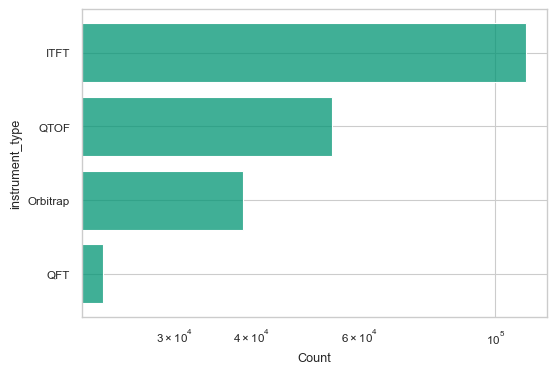

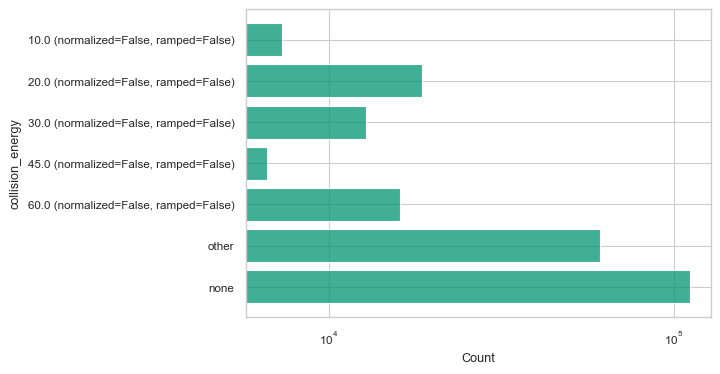

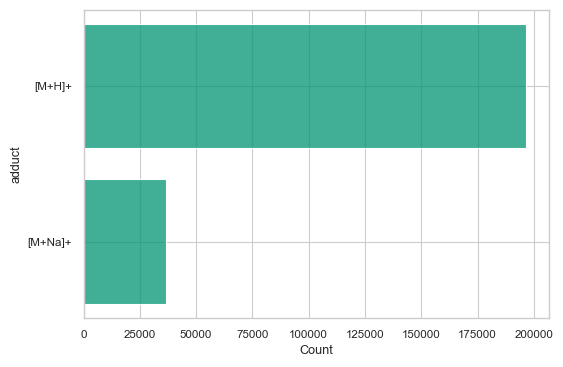

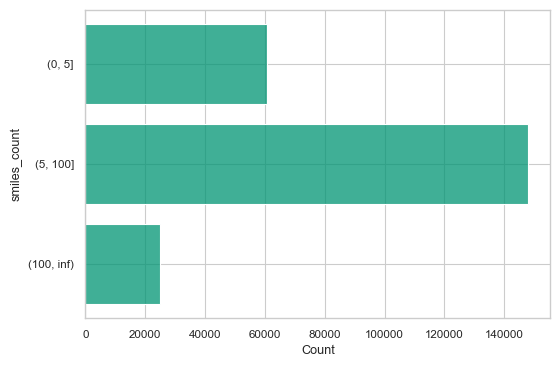

In [84]:
utils.init_plotting(figsize=(6, 4))
df_plot = df.copy()
df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

sns.histplot(y='instrument_type', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.savefig("../instr.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

df_plot['collision_energy'] = pd.Categorical(df_plot['collision_energy'], ['10.0 (normalized=False, ramped=False)', '20.0 (normalized=False, ramped=False)', 
                                                                           '30.0 (normalized=False, ramped=False)', '45.0 (normalized=False, ramped=False)',
                                                                          '60.0 (normalized=False, ramped=False)', 'other', 'none'])
sns.histplot(y='collision_energy', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.savefig("../ce.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

sns.histplot(y='adduct', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
# plt.xscale('log')
plt.savefig("../adduct.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

df_plot['smiles_count'] = pd.Categorical(df_plot['smiles_count'], ['(0, 5]', '(5, 100]', '(100, inf)'])
sns.histplot(y='smiles_count', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.savefig("../smiles.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

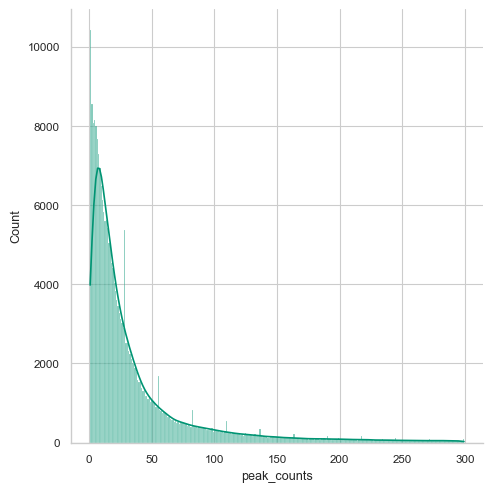

In [90]:
sns.displot(data=df_plot, x="peak_counts", kde=True)
plt.savefig("../peak_counts.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

In [91]:
print(df_plot['peak_counts'].mean())

36.536899325754135


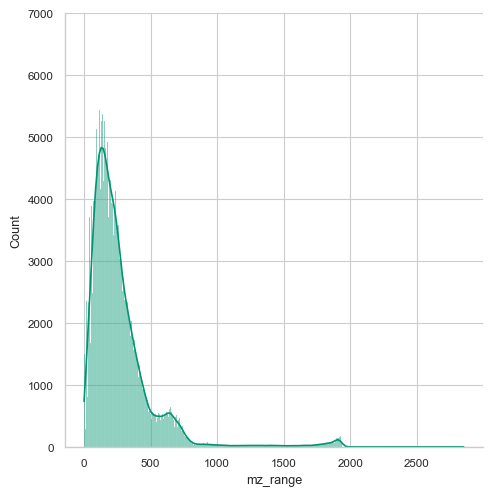

In [86]:
sns.displot(data=df_plot[df_plot['mz_range'] != 0], x="mz_range", kde=True)
plt.ylim(0,7000)
plt.savefig("../mz_range.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

In [13]:
print(df['mz_range'].mean())

266.4523432588185


In [39]:
from huggingface_hub import hf_hub_download
def hugging_face_download_cand(file_name: str) -> str:
    """
    Download a file from the Hugging Face Hub and return its location on disk.

    Args:
        file_name (str): Name of the file to download.
    """
    return hf_hub_download(
        repo_id="roman-bushuiev/MassSpecGym",  # TODO: not beta
        filename="data/molecules/" + file_name,
        repo_type="dataset",
    )


In [40]:
f = open(hugging_face_download_cand("MassSpecGym_retrieval_candidates_formula.json"), "rb")
cand_dict_form = json.load(f)
f.close()

(…)pecGym_retrieval_candidates_formula.json:   0%|          | 0.00/400M [00:00<?, ?B/s]

In [43]:
f = open(hugging_face_download_cand("MassSpecGym_retrieval_candidates_mass.json"), "rb")
cand_dict_mass = json.load(f)
f.close()

(…)ssSpecGym_retrieval_candidates_mass.json:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [72]:
cand_counts_form = {k: len(v) for k,v in cand_dict_form.items() if k in smiles_list}
cand_pd_form = pd.DataFrame(cand_counts_form.items(), columns=['Target', 'Number of Candidates'])

In [74]:
cand_counts_mass = {k: len(v) for k,v in cand_dict_mass.items() if k in smiles_list}
cand_pd_mass = pd.DataFrame(cand_counts_mass.items(), columns=['Target', 'Number of Candidates'])

In [75]:
cand_pd_form['Number of Candidates'].sum()

6871380

In [76]:
cand_pd_form['Number of Candidates'].mean()

214.66354264292409

In [77]:
cand_pd_mass['Number of Candidates'].sum()

8098784

In [79]:
cand_pd_mass['Number of Candidates'].mean()

253.00793502030615